In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

# defining global variable path
# image_path = "./galaxy_zoo/images_training_rev1/sample_class_1"
image_path = "./galaxy_zoo/images_training_rev1/all_class_1"


def loadImages(path):
    # Put files into lists and return them as one list of size 4
    image_files = sorted([os.path.join(path, file)
         for file in os.listdir(path) if file.endswith('.jpg')])
 
    return image_files

In [2]:
images = loadImages(image_path)

In [3]:
# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
# Display two images
def display_two(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

Original size (424, 424, 3)
RESIZED (220, 220, 3)


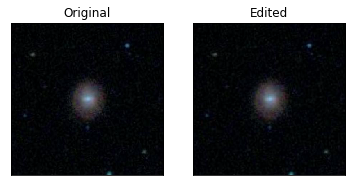

In [4]:
# Preprocessing
# def processing(data):
    # loading image
    # Getting 100 images to work with 
img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in images]
print('Original size',img[0].shape)

# setting dim of the resize
height = 220
width = 220
dim = (width, height)
res_img = []
for i in range(len(img)):
    res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
    res_img.append(res)

# Checcking the size
print("RESIZED", res_img[1].shape)

# Visualizing two images in the array
original = img[99]
resize = res_img[99]
display_two(original, resize)

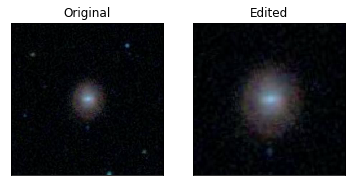

In [5]:
image = res_img[99]
crop = image[50:170, 50:170]
display_two(original, crop)

In [18]:
import tensorflow as tf 
x = tf.random.normal(shape=(220, 220, 3)) 
tf.image.central_crop(x, 0.5)

<tf.Tensor 'central_crop_5/Slice:0' shape=(110, 110, 3) dtype=float32>

In [ ]:
tf.image.crop_and_resize(
    image,
    boxes,
    box_indices,
    crop_size,
    method='bilinear',
    extrapolation_value=0,
    name=None
)

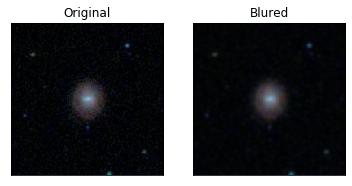

In [6]:
# Remove noise
# Gaussian
no_noise = []
for i in range(len(res_img)):
    blur = cv2.GaussianBlur(res_img[i],(5,5),cv2.BORDER_DEFAULT)
    no_noise.append(blur)


image = no_noise[99]
display_two(original, image, 'Original', 'Blured')

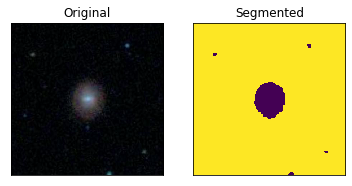

In [7]:
# Segmentation
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Displaying segmented images
display_two(original, thresh, 'Original', 'Segmented')

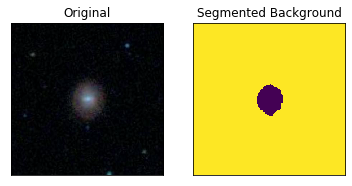

In [8]:
# Further noise removal
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

#Displaying segmented back ground
display_two(original, sure_bg, 'Original', 'Segmented Background')

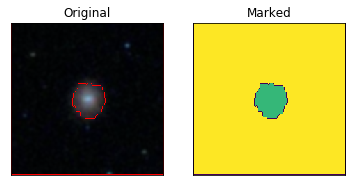

In [9]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

markers = cv2.watershed(image, markers)
image[markers == -1] = [255, 0, 0]

# Displaying markers on the image
display_two(image, markers, 'Original', 'Marked')

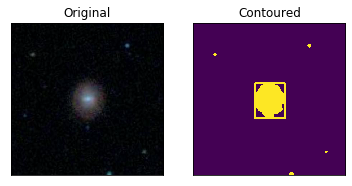

In [10]:
ret, thresh = cv2.threshold(gray, thresh=40, maxval=255, type=0)
img, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

max_numb = 0
for contour in contours:
    if len(contour) > max_numb:
        max_numb = len(contour)
        cnt = contour
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)
cv2.drawContours(image, [box], 0, (0, 0, 255), 2)

x,y,w,h = cv2.boundingRect(cnt)
cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Displaying contoured images
display_two(original, thresh, 'Original', 'Contoured')

#plt.imshow(img)
#plt.xticks([])
#plt.yticks([]);
#img = cv2.cvtColor(cv2.imread('./images_training_rev1/100143.jpg'), cv2.COLOR_BGR2RGB)
#img_crop = img[y:y+h, x:x+w]
#plt.imshow(img_crop);
#plt.xticks([])
#plt.yticks([])
#print(img_crop.shape)

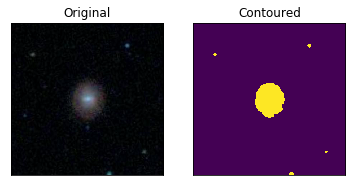

In [11]:
ret,thresh = cv2.threshold(gray,40,255,0)
img, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
perimeter = cv2.arcLength(cnt,True)
cnt = contours[1]
M = cv2.moments(cnt)
#print (M)
display_two(original, thresh, 'Original', 'Contoured')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


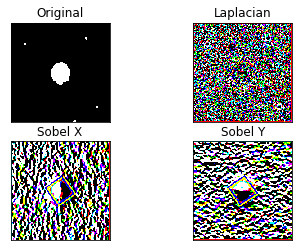

In [12]:
laplacian = cv2.Laplacian(image,cv2.CV_64F)
sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()